### Hard Negative Mining Analysis
This notebook explores the behavior of hard negative mining in object detection. Hard negative mining selects difficult samples for the model to improve training performance.

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [2]:
from modules.infererence.preprocessing import *
from modules.infererence.object_detection import *
from rectification.hard_negative_mining import *
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

In [3]:
folder_path = os.path.join('..', 'logistics')
images, image_names = load_image_and_name(folder_path)

In [4]:
ground_truths = load_ground_truth(folder_path, image_names)

In [5]:
# Train yolo model 1
yolo_version = 1

yolo_model_folder = f'yolo_model_{yolo_version}'
# Paths to the extracted files
model_config = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.cfg')
model_weights = os.path.join('..', f'yolo_model_{yolo_version}', f'yolov4-tiny-logistics_size_416_{yolo_version}.weights')
class_names = os.path.join('..', f'yolo_model_{yolo_version}', 'logistics.names')

yolo_model_1 = Model(model_config, model_weights, class_names)


In [6]:
predicted_raw = pred_raw_data(images, image_names, yolo_model_1)

In [7]:
output_dir = os.path.join('..', 'sample_data', 'sample_predictions')
save_predicted_raw(predicted_raw, output_dir, image_names)

File not found error for 4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9: [Errno 2] No such file or directory: '..\\sample_data\\sample_predictions\\4SqU3XHULjsH1J07w8FjZHpwQnY42a56WDL_4a7kZBjX_owoZkPihoYgMfWybV6xQ4bm8JdP599yg6k5fX6lMZzu_jpg.rf.564d126df55c75aa59bd0c50e6cadee9.txt'
File not found error for 4_z8126b7d060d92d74599e0618_f101f8274207a2608_d20161223_m174704_c001_v0001026_t0016_png_jpg.rf.59f72adb857e145d67124166b625a6d4: [Errno 2] No such file or directory: '..\\sample_data\\sample_predictions\\4_z8126b7d060d92d74599e0618_f101f8274207a2608_d20161223_m174704_c001_v0001026_t0016_png_jpg.rf.59f72adb857e145d67124166b625a6d4.txt'
File not found error for 4_z8126b7d060d92d74599e0618_f101fe32fb4e41aad_d20161222_m164911_c001_v0001036_t0005_png_jpg.rf.56809d382a028a414c2ede819c6a6990: [Errno 2] No such file or directory: '..\\sample_data\\sample_predictions\\4_z8126b7d060d92d74599e0618_f101fe32fb4e41aad

In [8]:
# Test case
pred_file = os.path.join('..', 'sample_data', 'sample_predictions', '-_10_jpg.rf.7216b8fd23d002354ad6cdd0d7691cd5.txt')
true_file = os.path.join('..', 'logistics', '-_10_jpg.rf.7216b8fd23d002354ad6cdd0d7691cd5.txt')
pred_data = load_txt_file(pred_file)
true_data = load_txt_file(true_file)
assigned_predictions = assign_true_object(pred_data, true_data)
print(assigned_predictions)

[[10.0, 0.6414252, 0.3817929, 0.24451384, 0.46021762, 0.7548875212669373, 0.75623619556427, 10.0, [0.615625, 0.38359375, 0.26875, 0.4359375]], [10.0, 0.6462253, 0.394841, 0.237947, 0.48452663, 0.9714358448982239, 0.9759900569915771, 10.0, [0.615625, 0.38359375, 0.26875, 0.4359375]], [8.0, 0.67976785, 0.65526605, 0.33050615, 0.58544165, 0.30694425106048584, 0.3069465160369873, 8.0, [0.71484375, 0.69453125, 0.3140625, 0.5515625]], [8.0, 0.72241694, 0.6576458, 0.38070366, 0.6143849, 0.5050157308578491, 0.5050488114356995, 8.0, [0.71484375, 0.69453125, 0.3140625, 0.5515625]], [8.0, 0.7335239, 0.7321628, 0.34721932, 0.4831697, 0.6420177221298218, 0.6420217156410217, 8.0, [0.71484375, 0.69453125, 0.3140625, 0.5515625]]]


In [9]:
# Test case
print(calculate_entropy_loss(assigned_predictions))

2.6175607804016394


In [10]:
prediction_dir = os.path.join('..', 'sample_data', 'sample_predictions')
annotation_dir = os.path.join('..', 'logistics')
hard_images = sample_hard_negatives(prediction_dir, annotation_dir, num_samples=500)

In [12]:
def load_txt_file(folder_path, image_names):
    image_info = {}

    # Loop through all files in the directory
    for file_name in image_names:
        # Build full path to the ground truth file
        txt_file_path = os.path.join(folder_path, file_name)
            
        # Read the ground truth annotations from the file
        try:
            with open(txt_file_path, 'r') as file:
                annotations = file.readlines()
            # Store the annotations for this image
            image_info[file_name] = [np.array(list(map(float, line.strip().split()))) for line in annotations]
        except FileNotFoundError:
            print(f"File not found: {txt_file_path}")

    return image_info

In [13]:
def yolo_to_corners(box, img_width, img_height):
    x_center, y_center, box_width, box_height = map(float, box)
    x_min = (x_center - box_width / 2) * img_width
    y_min = (y_center - box_height / 2) * img_height
    box_width = box_width * img_width
    box_height = box_height * img_height
    return [x_min, y_min, box_width, box_height]

In [14]:
def visualize_hard_images(hard_image_list, prediction_dir, annotation_dir):
    pred_info = load_txt_file(prediction_dir, hard_image_list)
    true_info = load_txt_file(annotation_dir, hard_image_list)

    for image_name in hard_image_list:
        # Load the image file corresponding to the annotation
        img_path = os.path.join(annotation_dir, image_name.replace('.txt', '.jpg'))
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Error: Could not load image {image_name}")
            continue
        
        img_height, img_width = img.shape[:2]
        predicted_boxes = []
        true_boxes = []
        
        # Extract predicted boxes
        if image_name in pred_info:
            for obj in pred_info[image_name]:
                pred_box = yolo_to_corners(obj[1:5], img_width, img_height)
                predicted_boxes.append(pred_box)
        
        # Extract ground truth boxes
        if image_name in true_info:
            for obj in true_info[image_name]:
                true_box = yolo_to_corners(obj[1:5], img_width, img_height)
                true_boxes.append(true_box)
        
        # Debug: Print box coordinates
        print(f"\nImage: {image_name}")
        print("Predicted Boxes:", predicted_boxes)
        print("True Boxes:", true_boxes)
        
        # Plot the image with bounding boxes
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        # Overlay predicted boxes in red
        for box in predicted_boxes:
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]), box[2], box[3],
                edgecolor='r', facecolor='none', lw=2))
        
        # Overlay ground truth boxes in green
        for box in true_boxes:
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]), box[2], box[3],
                edgecolor='g', facecolor='none', lw=2))
        
        plt.title(f"Image: {image_name.replace('.txt', '.jpg')}")
        plt.show()


Image: PPE_1338_jpg.rf.eaf913b3047533d4a52c8ce3418bb638.txt
Predicted Boxes: [[-3.2674918399999964, 35.4041792, 130.7439488, 94.3254784], [149.24718080000002, 12.139600000000002, 128.97027839999998, 91.0753984], [41.588671999999995, 30.258406400000002, 239.59027200000003, 313.4370048], [1.7556800000000106, 41.79332800000001, 157.83212799999998, 328.254624], [49.54979199999998, 70.0553824, 222.938048, 286.22280320000004], [472.4835584, 204.90865280000003, 74.4896, 164.57296639999998], [554.7239776, 444.856768, 86.19774079999999, 184.548736], [553.5559904, 454.50435200000004, 85.96251519999998, 188.093248], [443.69232351999995, 120.71327679999999, 17.29810496, 27.8994496], [339.19963488, 209.66579968000002, 19.45396544, 20.07120384], [616.00698784, 200.70217472000002, 23.49796032, 35.85619456], [278.0965472, 216.6501456, 28.446112, 20.1850464], [278.59093984, 214.42193600000002, 30.08900672, 26.96144], [285.2979776, 216.15365120000004, 25.449420800000002, 18.8592384], [316.357024, 228.5

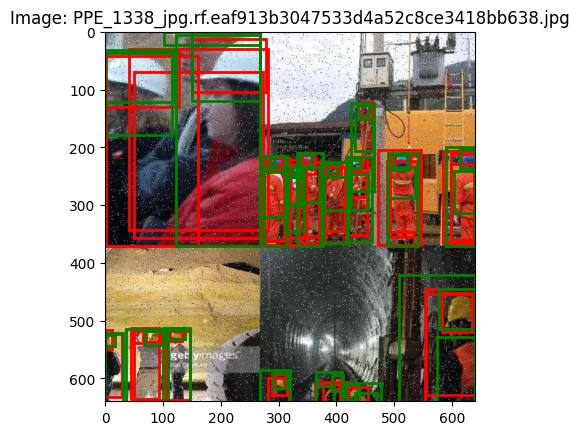


Image: ppe_0800_jpg.rf.f41b0f164b61bd32c81066cf332f8ba9.txt
Predicted Boxes: [[125.68579199999999, 15.054115199999991, 135.65696, 232.555616], [145.5241312, 7.328825600000002, 112.8181568, 239.4582912], [137.5727968, 14.634006399999997, 130.050976, 232.9315008], [478.03492479999994, 8.414054400000008, 172.180352, 250.98142719999998], [3.9696735999999966, 253.63992960000002, 101.7937856, 116.2719232], [551.5077888, 273.17205440000004, 90.42626560000001, 194.3359552], [1.5860256000000028, 272.14736960000005, 87.1511488, 308.946912], [1.80208704, 271.33936, 117.4820416, 311.577024], [550.1338175999999, 248.73571199999998, 96.3922048, 373.297344], [2.417431040000002, 278.548992, 119.12526079999999, 345.04192], [260.812768, 268.54319999999996, 206.771776, 365.258112], [533.1599584, 258.88533759999996, 105.96449919999999, 388.658304], [555.6799264, 262.0180128, 87.99425919999999, 384.2268352], [604.6360889599999, 84.9627136, 34.76071808, 147.2089472], [8.146060800000004, 249.43104639999999,

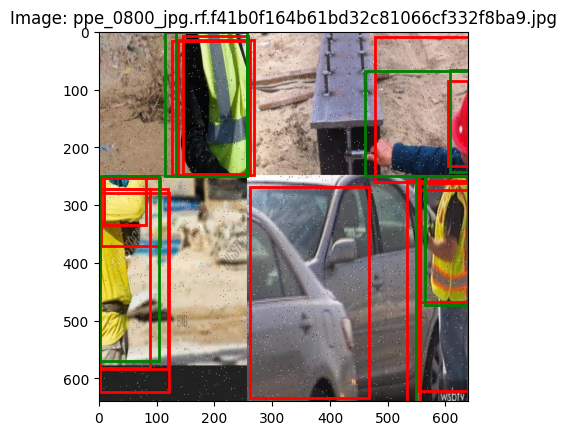


Image: 2720153-7576_jpg.rf.1f2edd0b056e341f8da85fd90f883009.txt
Predicted Boxes: [[207.16424, 1.6156588799999994, 84.23152, 35.510859520000004], [293.7397824, -2.3224032000000006, 86.2432768, 33.73365632], [389.81066239999996, 0.58881344, 77.03203839999999, 29.17694592], [470.0044736, -0.5873795199999998, 73.5666432, 29.050531199999998], [559.8664288, -2.479955839999999, 79.1617344, 24.62641024], [2.6723488000000017, 20.97987648, 54.1582016, 45.47044736], [211.02732160000002, 4.776854719999997, 78.1162368, 50.118198400000004], [3.8020153599999995, 28.781436799999994, 51.915808, 49.8603648], [6.447138560000001, 23.496089600000005, 53.13208576, 65.35767039999999], [400.9552224, 141.43324927999998, 51.557113599999994, 50.416279040000006], [470.0158112, 135.78664448, 80.01301120000001, 52.71313664], [487.012224, 131.0542784, 72.4819712, 55.1772288], [396.5756656, 192.4028736, 61.783132800000004, 54.8942976], [438.81685376, 189.5960448, 23.932628479999998, 56.9849344], [469.32510528, 194.9

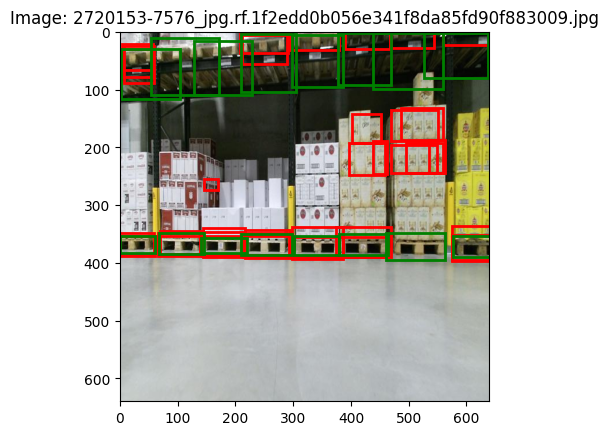


Image: ppe_0173_jpg.rf.03323bf114da8d194e5b4e33c8891e25.txt
Predicted Boxes: [[254.80626880000003, 5.963525760000001, 109.00643199999999, 119.64580480000001], [88.5926816, 33.26086400000001, 272.1759808, 376.123136], [65.3302208, 21.77923200000002, 298.2170496, 387.712832], [247.37371839999997, 413.826976, 114.45262720000001, 68.3315328], [212.048624, 430.30611200000004, 149.003808, 198.180352], [225.78915840000002, 433.52651839999993, 149.78117120000002, 191.9365312], [334.26364480000007, 414.14055679999996, 307.2417472, 226.665024], [361.10149119999994, 416.9940064000001, 299.4445824, 220.50901119999997], [-1.5050751999999967, 480.5121184, 188.921216, 158.5360064], [10.677107199999991, 480.403344, 192.9121024, 156.3403712], [268.93743359999996, 408.2373568, 77.6640384, 68.560768], [267.7265568, 407.23041408, 79.7006144, 76.90262784], [53.707385599999995, 472.40914879999997, 79.0629504, 87.0529344], [55.297769599999995, 474.5462752, 79.9320768, 89.96376959999999]]
True Boxes: [[248.0

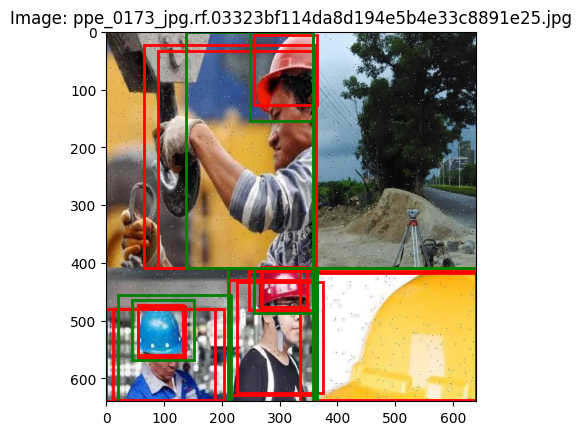


Image: ppe_0172_jpg.rf.18787e8d58d58c402b0a1257d5863704.txt
Predicted Boxes: [[2.038249600000004, -6.024294399999999, 78.3526144, 176.45414399999999], [9.1530208, -0.08942719999999404, 93.64492800000001, 153.39937279999998], [107.64030079999998, 5.550796800000004, 132.5265024, 148.5877888], [370.0023264, 0.44314560000000114, 91.1927872, 172.25642879999998], [5.126028799999993, 326.841824, 212.6330752, 196.88436480000001], [266.4241536, 210.55032640000002, 124.0487168, 423.85891200000003], [410.16807040000003, 352.98798400000004, 111.3039232, 163.2903872], [402.335888, 274.9941632, 140.649568, 311.9184128], [267.53713600000003, 281.275984, 120.547616, 364.32777600000003], [406.89462399999996, 273.388768, 129.620096, 368.40646399999997], [559.0502528, 328.78074879999997, 81.28707840000001, 300.140992], [556.9914496, 367.55791680000004, 84.8913408, 277.6092352], [7.3652608, 8.018217599999996, 56.2466752, 65.5832896], [393.43865919999996, 6.28580608, 68.6000576, 64.9303232], [6.6480137600

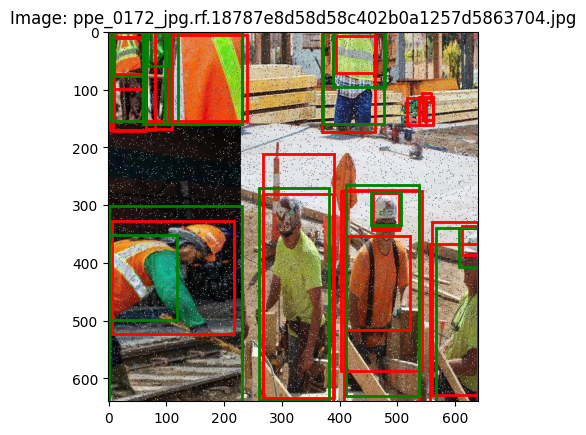


Image: 1579163630-345785_jpg.rf.77ae01f356823336d250a76be35cb609.txt
Predicted Boxes: [[83.77042880000002, 9.055772800000002, 168.66756479999998, 50.1525952], [216.9627776, 118.4800448, 138.6991488, 40.7141888], [213.6005792, 148.1213664, 147.0684352, 46.3635776], [208.3497504, 201.65509568, 161.88469120000002, 42.12357504], [207.25171840000002, 255.278432, 164.17614079999998, 42.036441599999996], [100.003904, 290.6085088, 129.1313664, 68.0081984], [210.561888, 303.050512, 154.3283456, 52.6062528], [207.1058304, 347.19027520000003, 151.3172992, 54.3882176], [-9.9971328, 374.72813440000004, 127.561792, 94.4621952], [95.50206719999998, 396.20790208000005, 151.391872, 73.22865024000001], [206.42711359999998, 397.9581216, 145.9520064, 56.1886272], [-7.856310400000002, 437.2672032, 125.25720319999999, 64.8378816], [-3.9219072000000033, -1.674329280000002, 91.29186560000001, 29.63535552], [6.815228800000002, -1.6908224000000005, 100.0416064, 28.26822016], [263.8480448, -2.13517312, 92.64574

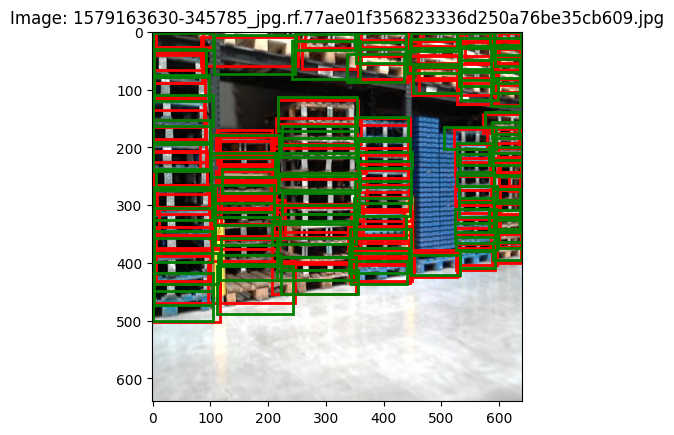


Image: PP02img286_jpg.rf.d142d7e9da5c6a8ee6c6e79be185bcd4.txt
Predicted Boxes: [[111.04552319999999, 207.6946336, 83.6173696, 217.4543552], [427.0229568000001, 167.82586560000001, 85.2217984, 423.4745408], [88.9097856, 329.8501248, 91.5631872, 151.9409152], [428.3020416, 205.74061440000003, 83.5897088, 402.50208], [-3.6562976000000003, 437.5823680000001, 124.9700288, 184.70047999999997], [-5.1333888000000005, 420.3092384, 130.7833472, 219.6807488], [495.597664, 537.168416, 130.173248, 98.518464], [273.2533632000001, 548.4895104, 174.99996159999998, 95.00305920000001], [494.15985600000005, 545.1529888, 127.244576, 94.24800640000001], [338.77713919999997, 119.70377920000001, 39.6985856, 128.5795392], [525.6407327999999, 125.1202688, 50.139590399999996, 159.997952], [43.6328096, 341.89748480000003, 50.0796096, 90.77015039999999], [45.529984, 360.9912528, 46.55575040000001, 79.1771744], [98.61230719999998, 346.4242048, 74.0224128, 132.95690240000002], [506.19267712, 414.85760319999997, 60

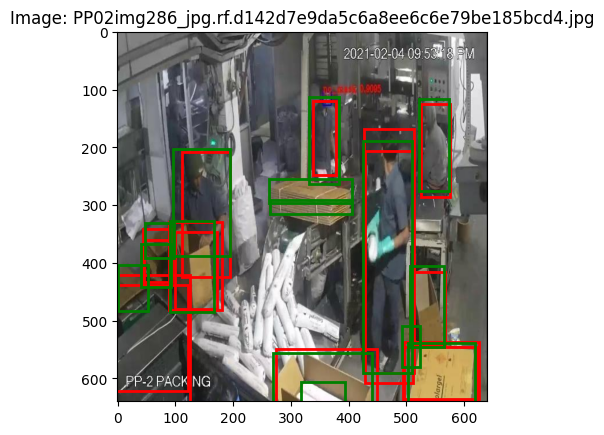


Image: 1564563913-8772337_jpg.rf.759512ff2710efd3d43d2a5409ba5d1b.txt
Predicted Boxes: [[-14.067622400000008, 89.0269376, 257.9011712, 73.8540928], [230.69345920000004, 133.23976, 204.69474559999998, 79.813344], [358.54095040000004, 394.3649216, 146.1100864, 65.3170944], [218.9092608, 425.2430848, 185.153088, 110.33056], [19.766896000000003, 480.3360096, 202.1370688, 98.6511808], [28.281196799999986, 511.8869152000001, 179.51750400000003, 81.4089664], [493.3797376, -0.9195193599999985, 69.13543680000001, 29.9522752], [526.0569632, 12.791080320000003, 51.40287360000001, 44.350233599999996], [473.8226784, 64.95939712, 65.3904192, 41.66350336], [506.7519744, 94.193016, 54.800652799999995, 40.3891232], [533.6126864, 98.30703360000001, 37.496419200000005, 38.2530048], [528.358336, 114.12366496000001, 52.179712, 34.99108288], [565.49059104, 120.2942688, 18.28230592, 30.51216], [478.4751616, 186.3619008, 41.260876800000005, 44.1866624], [511.67899199999994, 200.6763968, 41.9338432, 34.859366

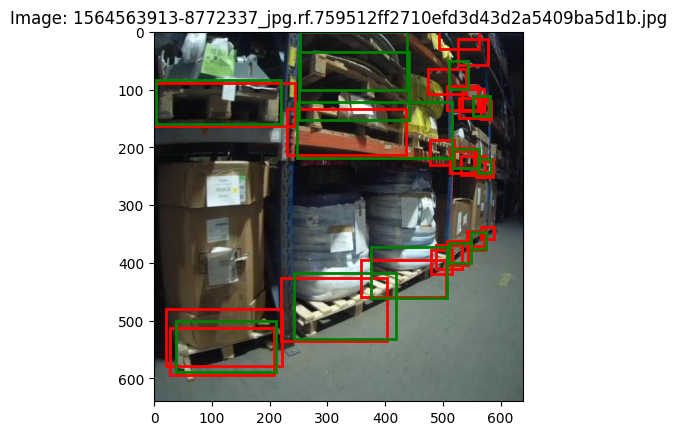


Image: 1576593528-1848657_jpg.rf.d139ca7f134a6ec65931d0cbee05864c.txt
Predicted Boxes: [[115.42571519999998, 0.27870912000000025, 47.5663488, 31.083776], [172.0999424, -2.066426240000001, 29.121920000000003, 19.751130240000002], [165.39138143999998, 0.6255260799999984, 39.18389312, 32.9589984], [342.71338144000003, -2.1139705600000003, 25.499189119999997, 28.23524736], [355.61709759999997, 1.7421971199999997, 49.0918848, 29.504151040000004], [392.80481088, -0.24955647999999941, 67.40682624, 33.15296384], [341.68352768, 16.06138304, 35.31147264, 39.6442304], [142.7587072, 41.445356800000006, 39.2491776, 45.4546048], [345.15883648, 41.321907200000005, 33.81237504, 44.1295808], [359.11283519999995, 42.16604608, 38.0463296, 46.88719744], [143.4273824, 61.043974399999996, 45.082771199999996, 49.1475712], [343.58176192, 66.7520096, 29.23860096, 43.823558399999996], [367.13889152, 63.54465791999999, 37.91032576, 50.87115776], [381.79967584, 57.880304, 35.896110719999996, 60.354579199999996],

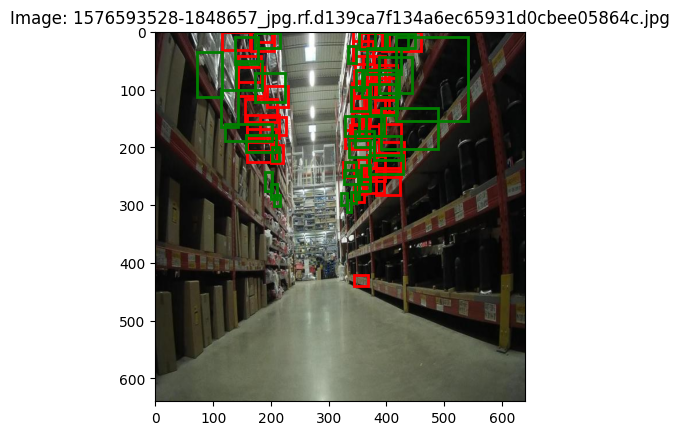


Image: 1583415993-8918884_jpg.rf.c6fed70107ff1216243b3dac6046e6f1.txt
Predicted Boxes: [[342.43043520000003, 403.56766719999996, 156.2377536, 120.4211456], [385.302784, 418.6037632, 144.583168, 115.3080576], [497.21714240000006, 499.17394880000006, 137.6316736, 113.3319744], [232.0640576, 2.42285568, 61.320947200000006, 30.833840640000002], [237.57609599999998, 0.8459247999999997, 83.77184, 27.7238944], [-1.088616, 151.19590912, 16.51876544, 31.61441536], [21.233448, 173.37338016, 26.054952319999998, 26.50840768], [27.451019199999998, 275.882288, 23.788867200000002, 25.62512], [42.3380576, 267.8595024, 23.9319616, 18.978416], [95.35264319999999, 265.82955072, 29.2969664, 19.64427136], [117.80620480000002, 268.9498928, 28.7329856, 18.7351968], [165.3678384, 277.62027744, 32.797072, 18.92036672], [165.13101120000002, 276.5877024, 42.0523968, 24.489747199999996], [1.8897663999999992, 283.35666752, 32.3903744, 31.18934656], [204.0558112, 294.73354336, 47.3176512, 39.18625088], [212.399001

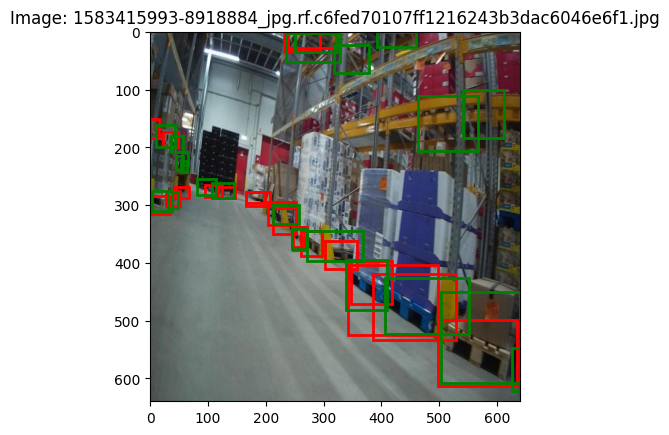

In [15]:
random_hard_images = random.sample(hard_images, 10)
visualize_hard_images(random_hard_images, prediction_dir, annotation_dir)

### Analysis of the behavior of the hard negative mining strategy

1. **Type of Hard Samples Identified**
- Multiple objects: The images identified as hard negatives often contain multiple overlapping objects. This increases the difficulty for the model as it has to distinguish between objects in close proximity.
- Crowded scenes: Images with cluttered backgrounds or complex environments tend to be hard negatives. In these scenarios, the model might struggle to differentiate between the actual objects and the background clutter.
- Small objects: If certain images have very small objects, the model may struggle to detect them accurately.
- Objects at various scales and crop boundaries: Hard negatives often include objects of varying sizes or only are partially visible, which may challenge the model’s ability to generalize across scales and boundaries.

2. **Impact of Different Parameters on Mining Results**
- Objectiveness threshold: If the confidence threshold for detecting objects is set too high, the model may ignore smaller or partially visible objects, leading to missed detections that could be added to the hard negatives.
- IoU Threshold for box association: The IoU threshold controls how two boxes are associated. Only when IoU between a predicted box and a true box is higher than the IoU Threshold, the two boxes are considered associated. A higher threshold might filter out some boxes with slightly overlap and be eliminated.
- Loss Function Weights: Since the total loss is a combination of classification and localization (bounding box) losses, changing their relative weights can influence the selection of hard negatives. For instance, increasing the weight of classification loss could result in the selection of samples where the class predictions are inaccurate, regardless of localization accuracy.

3. **Strategies for Model Improvement Based on Analysis**
- Augmenting hard negatives: Use these hard samples to focus the model’s learning on challenging cases by augmenting the dataset.
- Fine-Tuning for overlapping predictions: The model’s performance on cluttered or highly dense regions can potentially be improved by adjusting non-maximum suppression (NMS) parameters.
